In [94]:
import numpy as np # linear algebra
import datetime
from numpy import asarray
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px
plt.style.use('fivethirtyeight')

In [95]:
df = pd.read_csv("all data/newoldmeter_1.csv")
df['ds'] = pd.to_datetime(df['Time(Unix timestamp)'], unit='ms')
df['ds'] = df['ds'].dt.round('min')
# df = df[287::288]
dataset = df
dataset = df.set_index("ds")
dataset.index = pd.to_datetime(dataset.index, format='%d,%m,%Y %H,%M,%s')
dataset.drop('Meter_ID', axis=1, inplace=True)
dataset.drop('Time(Unix timestamp)', axis=1, inplace=True)
dataset = dataset.sort_index()

# dataset = dataset['Consumption(watt-hour)']
dataset = dataset.resample('H').mean()
dataset = dataset.fillna(method='ffill')
dataset = dataset.fillna(method='bfill')
# dataset.info()

In [96]:
# dataset = pd.read_csv('fake_merged.csv', index_col=[1], parse_dates=[1])
# dataset.drop('Unnamed: 0', axis=1, inplace=True)

# dataset

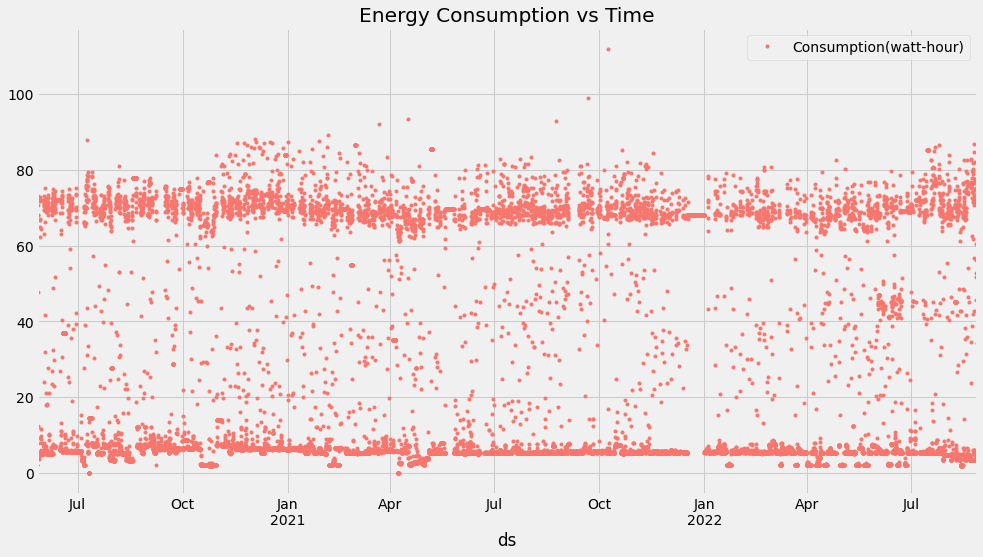

In [97]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dataset.plot(style='.', figsize=(15,8), color=color_pal[0], title='Energy Consumption vs Time')

### Cutting Data for Testing


In [98]:
split_date = '01-Oct-2021'
df_train = dataset.loc[dataset.index <= split_date].copy()
df_test = dataset.loc[dataset.index > split_date].copy()

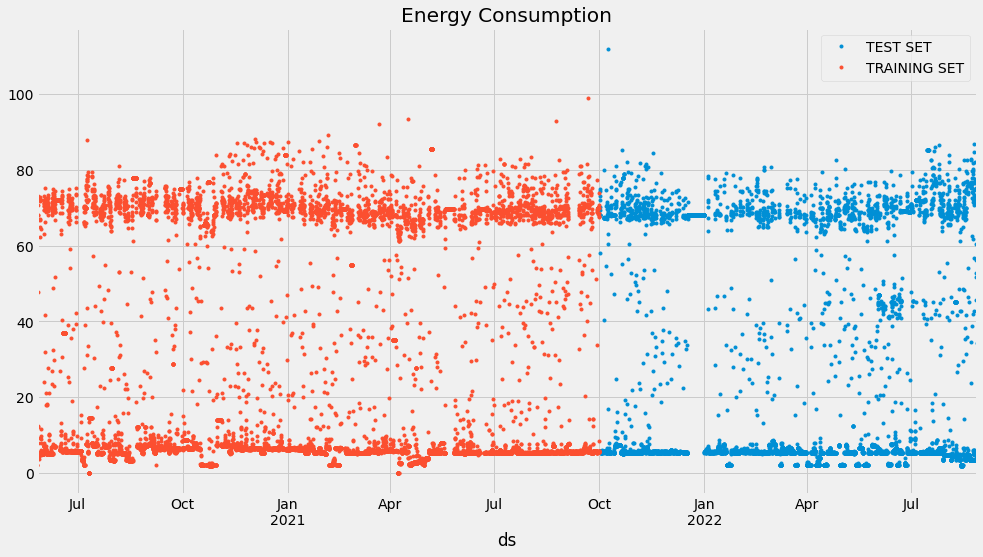

In [99]:
_ = df_test \
    .rename(columns={'Consumption(watt-hour)': 'TEST SET'}) \
    .join(df_train.rename(columns={'Consumption(watt-hour)': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,8), title='Energy Consumption', style='.')

In [100]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['second'] = df['date'].dt.second
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['hour','minute','second','dayofweek','month','year',
            'dayofyear','dayofmonth']]
        
    if label:
        y = df[label]
        return X, y
    return X

In [101]:
X_train, y_train = create_features(df_train, label='Consumption(watt-hour)')
X_test, y_test = create_features(df_test, label='Consumption(watt-hour)')
X_test.head(2000)

,hour,minute,second,dayofweek,month,year,dayofyear,dayofmonth
ds,,,,,,,,
2021-10-01 01:00:00,1,0,0,4,10,2021,274,1
2021-10-01 02:00:00,2,0,0,4,10,2021,274,1
2021-10-01 03:00:00,3,0,0,4,10,2021,274,1
2021-10-01 04:00:00,4,0,0,4,10,2021,274,1
2021-10-01 05:00:00,5,0,0,4,10,2021,274,1
...,...,...,...,...,...,...,...,...
2021-12-23 04:00:00,4,0,0,3,12,2021,357,23
2021-12-23 05:00:00,5,0,0,3,12,2021,357,23
2021-12-23 06:00:00,6,0,0,3,12,2021,357,23


### xgboost Model


In [102]:
reg = xgb.XGBRegressor(n_estimators=10000, max_depth=10, learning_rate=0.3, subsample=0.5, colsample_bytree=0.5, n_jobs=-1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False)  # Change verbose to True if you want to see it train

# string = "21 Aug 2023  06:31:09"
# date = datetime.datetime.strptime(string, "%d %b %Y  %H:%M:%S")


# row = [[16, 31, 9, 1, 8, 2022, 239, 27],[date.hour, date.minute, date.second, date.isoweekday(), date.month, date.year, 239, date.day]]
# yhat = reg.predict(asarray([row[1]]))

# print("prediction: ", yhat[0])

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Feature Importance


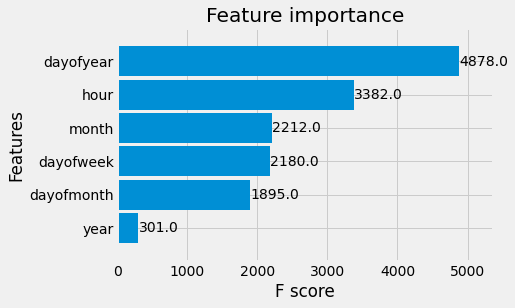

In [103]:
_ = plot_importance(reg, height=0.9)

In [104]:
df_test['Wh_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test], sort=True)

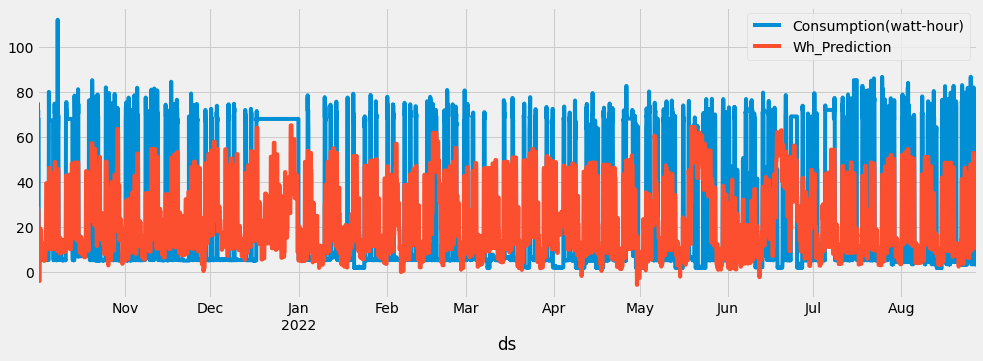

In [105]:
_ = df_all[['Consumption(watt-hour)','Wh_Prediction']].plot(figsize=(15,5))

In [106]:
df_all.min()

Consumption(watt-hour)               1.833333
Wh_Prediction                       -5.609937
date                      2021-10-01 01:00:00
dayofmonth                                  1
dayofweek                                   0
dayofyear                                   1
hour                                        0
minute                                      0
month                                       1
second                                      0
year                                     2021
dtype: object

In [107]:
# filter out and count the data that has negative values
df_all[df_all['Wh_Prediction'] < 0]

,Consumption(watt-hour),Wh_Prediction,date,dayofmonth,dayofweek,dayofyear,hour,minute,month,second,year
ds,,,,,,,,,,,
2021-10-01 15:00:00,5.714286,-3.891347,2021-10-01 15:00:00,1,4,274,15,0,10,0,2021
2021-10-01 16:00:00,5.500000,-3.891347,2021-10-01 16:00:00,1,4,274,16,0,10,0,2021
2021-10-01 17:00:00,5.666667,-3.891347,2021-10-01 17:00:00,1,4,274,17,0,10,0,2021
2021-10-01 18:00:00,5.500000,-3.891347,2021-10-01 18:00:00,1,4,274,18,0,10,0,2021
2021-10-01 19:00:00,5.500000,-3.891347,2021-10-01 19:00:00,1,4,274,19,0,10,0,2021
2021-10-01 20:00:00,5.500000,-3.891347,2021-10-01 20:00:00,1,4,274,20,0,10,0,2021
2021-10-01 21:00:00,5.666667,-3.891347,2021-10-01 21:00:00,1,4,274,21,0,10,0,2021
2021-10-01 22:00:00,5.500000,-3.891347,2021-10-01 22:00:00,1,4,274,22,0,10,0,2021
2021-10-01 23:00:00,5.666667,-3.891347,2021-10-01 23:00:00,1,4,274,23,0,10,0,2021


### First month of Prediction


In [108]:
# df_all.head(30)

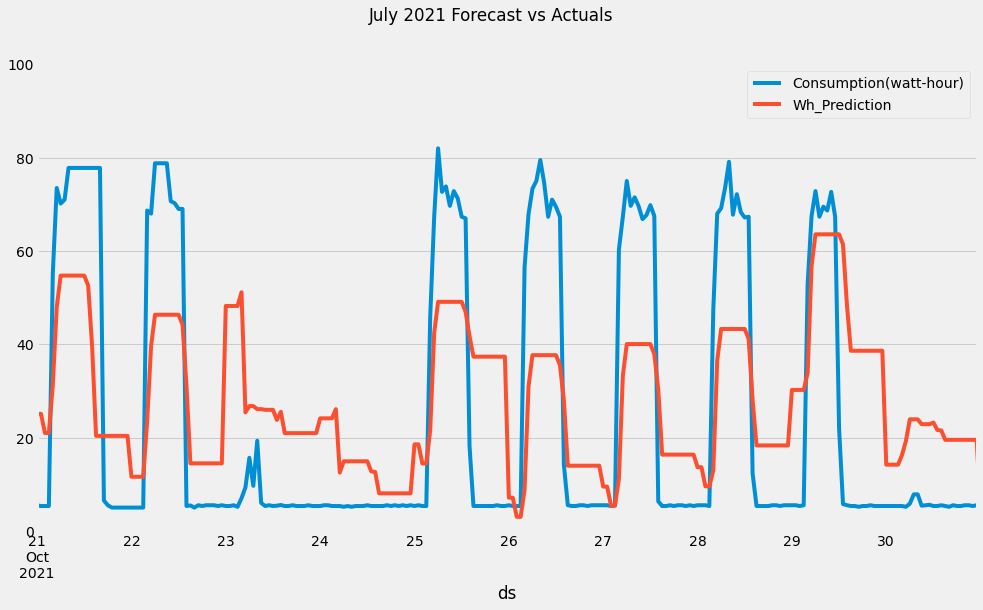

In [109]:
# Plot the forecast with the actuals

# threshold = 106

f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)
# plt.axhline(threshold, color='black', label='threshold', alpha=0.5)
_ = df_all[['Consumption(watt-hour)', 'Wh_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='10-21-2021 00:00:00', upper='10-30-2021 23:55:00')
ax.set_ylim(0, 100)
plot = plt.suptitle('July 2021 Forecast vs Actuals')

In [110]:
# check the r2 score of the prediction
from sklearn.metrics import r2_score
r2_score(df_all['Consumption(watt-hour)'], df_all['Wh_Prediction'])

0.27051167456439706

### Prediction with Actuals


In [111]:
df_all[df_all['Wh_Prediction'] < 0]


,Consumption(watt-hour),Wh_Prediction,date,dayofmonth,dayofweek,dayofyear,hour,minute,month,second,year
ds,,,,,,,,,,,
2021-10-01 15:00:00,5.714286,-3.891347,2021-10-01 15:00:00,1,4,274,15,0,10,0,2021
2021-10-01 16:00:00,5.500000,-3.891347,2021-10-01 16:00:00,1,4,274,16,0,10,0,2021
2021-10-01 17:00:00,5.666667,-3.891347,2021-10-01 17:00:00,1,4,274,17,0,10,0,2021
2021-10-01 18:00:00,5.500000,-3.891347,2021-10-01 18:00:00,1,4,274,18,0,10,0,2021
2021-10-01 19:00:00,5.500000,-3.891347,2021-10-01 19:00:00,1,4,274,19,0,10,0,2021
2021-10-01 20:00:00,5.500000,-3.891347,2021-10-01 20:00:00,1,4,274,20,0,10,0,2021
2021-10-01 21:00:00,5.666667,-3.891347,2021-10-01 21:00:00,1,4,274,21,0,10,0,2021
2021-10-01 22:00:00,5.500000,-3.891347,2021-10-01 22:00:00,1,4,274,22,0,10,0,2021
2021-10-01 23:00:00,5.666667,-3.891347,2021-10-01 23:00:00,1,4,274,23,0,10,0,2021


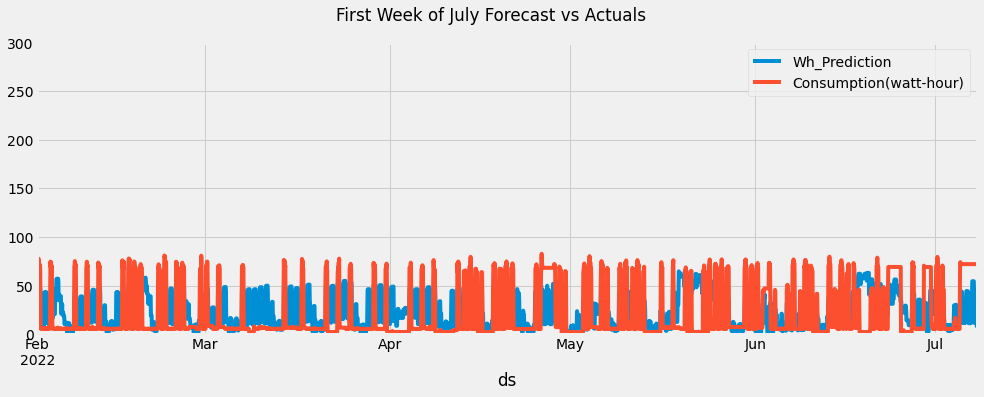

In [112]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Wh_Prediction','Consumption(watt-hour)']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-01-2022', upper='07-08-2022')
ax.set_ylim(0, 300)
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Error Metrics on Test Set


In [113]:
mean_squared_error(y_true=df_test['Consumption(watt-hour)'],
                   y_pred=df_test['Wh_Prediction'])

565.4804875731774

In [114]:
mean_absolute_error(y_true=df_test['Consumption(watt-hour)'],
                   y_pred=df_test['Wh_Prediction'])

17.28119833427962

In [115]:
# r2 score
r2_score(y_true=df_test['Consumption(watt-hour)'],
                     y_pred=df_test['Wh_Prediction'])
                     

0.27051167456439706

### mean absolute percent error


In [116]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [117]:
mean_absolute_percentage_error(y_true=df_test['Consumption(watt-hour)'],
                   y_pred=df_test['Wh_Prediction'])

223.79694806548952

### Look at Worst and Best Predicted Days


In [118]:
df_test['error'] = df_test['Consumption(watt-hour)'] - df_test['Wh_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth','hour']) \
    .mean()[['Consumption(watt-hour)','Wh_Prediction','error','abs_error']]

In [119]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Consumption(watt-hour)  Wh_Prediction      error  \
year month dayofmonth hour                                                     
2022 6     19         23                  2.000000      62.953320 -60.953320   
                      22                  2.000000      62.953320 -60.953320   
                      21                  2.000000      62.953320 -60.953320   
                      20                  2.000000      62.953320 -60.953320   
                      18                  2.000000      62.953320 -60.953320   
                      17                  2.166667      62.953320 -60.786653   
                      16                  2.181818      62.953320 -60.771501   
                      19                  2.363636      62.953320 -60.589683   
                      9                   2.000000      62.096478 -60.096478   
                      10                  2.000000      62.096478 -60.096478   

                            abs_error  
year month dayofmonth hour             
2022 6     19         23    60.953320  
                      22    60.953320  
                      21    60.953320  
                      20    60.953320  
                      18    60.953320  
                      17    60.786653  
                      16    60.771501  
                      19    60.589683  
                      9     60.096478  
                      10    60.096478

In [120]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Consumption(watt-hour)  Wh_Prediction     error  \
year month dayofmonth hour                                                    
2022 1     6          3                   5.500000       5.484189  0.015811   
                      2                   5.500000       5.484189  0.015811   
     6     6          15                  5.333333       5.356643 -0.023309   
2021 10    3          3                   5.500000       5.474792  0.025208   
                      2                   5.500000       5.474792  0.025208   
                      0                   5.500000       5.474792  0.025208   
2022 2     8          18                  5.666667       5.640067  0.026600   
     4     21         3                   6.333333       6.299859  0.033475   
     3     6          0                   5.500000       5.461118  0.038882   
                      3                   5.500000       5.461118  0.038882   

                            abs_error  
year month dayofmonth hour             
2022 1     6          3      0.015811  
                      2      0.015811  
     6     6          15     0.023309  
2021 10    3          3      0.025208  
                      2      0.025208  
                      0      0.025208  
2022 2     8          18     0.026600  
     4     21         3      0.033475  
     3     6          0      0.038882  
                      3      0.038882

### Plotting some best/worst predicted days


In [121]:
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# _ = df_all[['Wh_Prediction','Consumption(watt-hour)']].plot(ax=ax,
#                                               style=['-','-'])
# ax.set_ylim(0, 300)
# ax.set_xbound(lower='07-01-2022', upper='08-01-2022')
# plot = plt.suptitle('07-1 - Worst Predicted Day')

### Best Predicted Days


In [122]:
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# _ = df_all[['Wh_Prediction','Consumption(watt-hour)']].plot(ax=ax,
#                                               style=['-','-'])
# ax.set_ylim(0, 300)
# ax.set_xbound(lower='07-01-2022', upper='08-01-2022')
# plot = plt.suptitle('August 1, 2021 - Best Predicted Day')

In [123]:
# save in JSON format

# reg.save_model("model_4/model_sklearn.json")
# # save in text format
# reg.save_model("model_4/model_sklearn.txt")

In [124]:
# model2 = xgb.XGBRegressor()
# model2.load_model("model_sklearn.json")

In [125]:
# test_model = model2.predict(X_test)

In [126]:
# plot test_model with px
# fig = px.line(test_model)
# fig.show()